In [29]:
# 데이터 편향 탐색에 필요한 라이브러리 가져오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count
)


In [23]:
# 데이터 가져오기(임의의 데이터)
data = fetch_adult(as_frame=True)
# UCI 성인 연봉데이터
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['race']
sex.value_counts()

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64

In [24]:
#모델 실행
#임의의 데이터로 전처리가 되어 있다는 전제하게 테스트 진행
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

In [25]:
y_pred = classifier.predict(X)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=race)
#
sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=race)
#
pr = MetricFrame(metrics=precision_score, y_true=y_true, y_pred=y_pred, sensitive_features=race)
#
fpr = MetricFrame(metrics=false_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=race)
#
tpr = MetricFrame(metrics=true_positive_rate, y_true=y_true, y_pred=y_pred, sensitive_features=race)

In [26]:
print("----- Accuracy_Score -----\n",mf.by_group)
print("----- Selection_Rate -----\n",sr.by_group)
print("----- Precision_Score -----\n",pr.by_group)
print("----- False_Positive_Rate -----\n",fpr.by_group)
print("----- True_Positive_Rate -----\n",tpr.by_group)

----- Accuracy_Score -----
 race
Amer-Indian-Eskimo    0.921277
Asian-Pac-Islander    0.807768
Black                 0.913127
Other                 0.906404
White                 0.836502
Name: accuracy_score, dtype: float64
----- Selection_Rate -----
 race
Amer-Indian-Eskimo    0.059574
Asian-Pac-Islander    0.266623
Black                 0.071078
Other                 0.088670
White                 0.172429
Name: selection_rate, dtype: float64
----- Precision_Score -----
 race
Amer-Indian-Eskimo    0.821429
Asian-Pac-Islander    0.644444
Black                 0.738739
Other                 0.666667
White                 0.762394
Name: precision_score, dtype: float64
----- False_Positive_Rate -----
 race
Amer-Indian-Eskimo    0.012048
Asian-Pac-Islander    0.129730
Black                 0.021122
Other                 0.033708
White                 0.054919
Name: false_positive_rate, dtype: float64
----- True_Positive_Rate -----
 race
Amer-Indian-Eskimo    0.418182
Asian-Pac-Islander  

array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'true positive rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

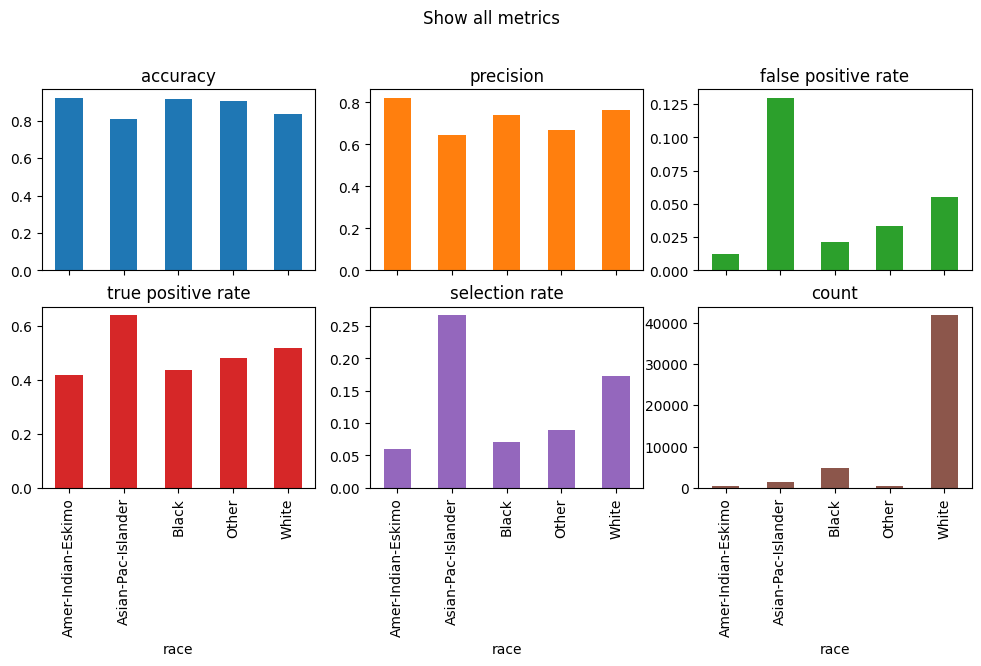

In [27]:
metrics = {
    "accuracy": accuracy_score,
    'precision': precision_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,    
    "selection rate": selection_rate,
    'count': count
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=race
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#Mitigating disparity

In [30]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

In [31]:
constraint = DemographicParity()
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=race)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x00000216AE01D6D0>,
                      estimator=DecisionTreeClassifier(max_depth=4,
                                                       min_samples_leaf=10),
                      nu=0.0008201769357601916)

In [32]:
y_pred_mitigated = mitigator.predict(X)

In [33]:
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=race)
sr_mitigated.overall

0.17482904057982884

In [34]:
sr_mitigated.by_group

race
Amer-Indian-Eskimo    0.165957
Asian-Pac-Islander    0.187623
Black                 0.167343
Other                 0.179803
White                 0.175255
Name: selection_rate, dtype: float64

#1 Metrics with Multiple Features

In [35]:
import functools

import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from fairlearn.datasets import fetch_adult
from fairlearn.metrics import MetricFrame, count, selection_rate

In [36]:
data = fetch_adult()
X_raw = data.data
y = (data.target == ">50K") * 1

In [37]:
def race_transform(input_str):
    """Reduce values to White, Black and Other."""
    result = "Other"
    if input_str == "White" or input_str == "Black":
        result = input_str
    return result


X_raw["race"] = X_raw["race"].map(race_transform).fillna("Other").astype("category")
print(np.unique(X_raw["race"]))

['Black' 'Other' 'White']


C:\Users\Jay\AppData\Local\Temp\ipykernel_19668\1847876707.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_raw["race"] = X_raw["race"].map(race_transform).fillna("Other").astype("category")


In [38]:
def marriage_transform(m_s_string):
    """Perform some simple manipulations."""
    result = "Low"
    if m_s_string.startswith("Married"):
        result = "Medium"
    elif m_s_string.startswith("Widowed"):
        result = "High"
    return result


def occupation_transform(occ_string):
    """Perform some simple manipulations."""
    result = "Small"
    if occ_string.startswith("Machine"):
        result = "Large"
    return result


col_credit = X_raw["marital-status"].map(marriage_transform).fillna("Low")
col_credit.name = "Credit Score"
col_loan_size = X_raw["occupation"].map(occupation_transform).fillna("Small")
col_loan_size.name = "Loan Size"

A = X_raw[["race", "sex"]]
A["Credit Score"] = col_credit
A["Loan Size"] = col_loan_size
A

C:\Users\Jay\AppData\Local\Temp\ipykernel_19668\4184408968.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A["Credit Score"] = col_credit
C:\Users\Jay\AppData\Local\Temp\ipykernel_19668\4184408968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A["Loan Size"] = col_loan_size


,race,sex,Credit Score,Loan Size
0,Black,Male,Low,Large
1,White,Male,Medium,Small
2,White,Male,Medium,Small
3,Black,Male,Medium,Large
4,White,Female,Low,Small
...,...,...,...,...
48837,White,Female,Medium,Small
48838,White,Male,Medium,Large
48839,White,Female,High,Small
48840,White,Male,Low,Small


In [39]:
(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.3, random_state=54321, stratify=y
)

# Ensure indices are aligned between X, y and A,
# after all the slicing and splitting of DataFrames
# and Series

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

In [40]:
numeric_transformer = Pipeline(
    steps=[("impute", SimpleImputer()), ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

In [41]:
unmitigated_predictor = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(solver="liblinear", fit_intercept=True)),
    ]
)

In [42]:
unmitigated_predictor.fit(X_train, y_train)
y_pred = unmitigated_predictor.predict(X_test)

In [43]:
print("Selection Rate:", selection_rate(y_test, y_pred))
print("fbeta:", skm.fbeta_score(y_test, y_pred, beta=0.6))

Selection Rate: 0.1947041561454992
fbeta: 0.6827826864569057


In [44]:
fbeta_06 = functools.partial(skm.fbeta_score, beta=0.6, zero_division=1)

metric_fns = {"selection_rate": selection_rate, "fbeta_06": fbeta_06, "count": count}

grouped_on_sex = MetricFrame(
    metrics=metric_fns, y_true=y_test, y_pred=y_pred, sensitive_features=A_test["sex"]
)

In [45]:
assert grouped_on_sex.overall["selection_rate"] == selection_rate(y_test, y_pred)
assert grouped_on_sex.overall["fbeta_06"] == skm.fbeta_score(y_test, y_pred, beta=0.6)
print(grouped_on_sex.overall)

selection_rate        0.194704
fbeta_06              0.682783
count             14653.000000
dtype: float64


In [46]:
grouped_on_race = MetricFrame(
    metrics=metric_fns, y_true=y_test, y_pred=y_pred, sensitive_features=A_test["race"]
)

In [47]:
assert (grouped_on_sex.overall == grouped_on_race.overall).all()

In [48]:
grouped_on_race.by_group

,selection_rate,fbeta_06,count
race,,,
Black,0.068198,0.592125,1437.0
Other,0.167630,0.693717,692.0
White,0.210715,0.686081,12524.0


In [49]:
random_weights = np.random.rand(len(y_test))

example_sample_params = {
    "selection_rate": {"sample_weight": random_weights},
    "fbeta_06": {"sample_weight": random_weights},
}


grouped_with_weights = MetricFrame(
    metrics=metric_fns,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test["sex"],
    sample_params=example_sample_params,
)

In [50]:
assert grouped_with_weights.overall["selection_rate"] == selection_rate(
    y_test, y_pred, sample_weight=random_weights
)
assert grouped_with_weights.overall["fbeta_06"] == skm.fbeta_score(
    y_test, y_pred, beta=0.6, sample_weight=random_weights
)
print(grouped_with_weights.overall)

selection_rate        0.197296
fbeta_06              0.684384
count             14653.000000
dtype: float64


In [51]:
grouped_with_weights.by_group

,selection_rate,fbeta_06,count
sex,,,
Female,0.071859,0.626207,4838.0
Male,0.258569,0.692918,9815.0


In [52]:
grouped_on_race.group_min()

selection_rate    0.068198
fbeta_06          0.592125
count                692.0
dtype: object

In [53]:
grouped_on_race.difference(method="between_groups")

selection_rate        0.142518
fbeta_06              0.101591
count             11832.000000
dtype: float64

In [54]:
grouped_on_race.ratio(method="between_groups")

selection_rate    0.323648
fbeta_06          0.853555
count             0.055254
dtype: float64

In [55]:
grouped_on_race.ratio(method="to_overall")

selection_rate    0.350263
fbeta_06          0.867223
count             0.047226
dtype: float64

In [56]:
grouped_on_race_and_sex = MetricFrame(
    metrics=metric_fns,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test[["race", "sex"]],
)

In [57]:
assert (grouped_on_race_and_sex.overall == grouped_on_race.overall).all()
grouped_on_race_and_sex.by_group

selection_rate  fbeta_06   count
race  sex                                     
Black Female        0.032258  0.630316   713.0
      Male          0.103591  0.580624   724.0
Other Female        0.070866  0.503704   254.0
      Male          0.223744  0.728972   438.0
White Female        0.075433  0.642076  3871.0
      Male          0.271235  0.692069  8653.0

In [58]:
grouped_on_race_and_sex.group_min()

selection_rate    0.032258
fbeta_06          0.503704
count                254.0
dtype: object

In [59]:
grouped_on_race_and_sex.ratio(method="between_groups")

selection_rate    0.118930
fbeta_06          0.690978
count             0.029354
dtype: float64

In [60]:
cond_credit_score = MetricFrame(
    metrics=metric_fns,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test[["race", "sex"]],
    control_features=A_test["Credit Score"],
)

In [61]:
cond_credit_score.overall

,selection_rate,fbeta_06,count
Credit Score,,,
High,0.036170,0.664928,470.0
Low,0.022924,0.549994,7285.0
Medium,0.386924,0.695034,6898.0


In [62]:
cond_credit_score.by_group

selection_rate  fbeta_06   count
Credit Score race  sex                                     
High         Black Female        0.000000  0.000000    54.0
                   Male          0.066667  1.000000    15.0
             Other Female        0.000000  1.000000    21.0
                   Male          0.000000  1.000000     4.0
             White Female        0.019608  0.529595   306.0
                   Male          0.142857  0.759305    70.0
Low          Black Female        0.007030  0.626728   569.0
                   Male          0.020513  0.563536   390.0
             Other Female        0.012048  0.519084   166.0
                   Male          0.037267  0.693878   161.0
             White Female        0.015084  0.525773  2917.0
                   Male          0.033420  0.550250  3082.0
Medium       Black Female        0.211111  0.639653    90.0
                   Male          0.206897  0.577576   319.0
             Other Female        0.238806  0.500000    67.0
                   Male          0.336996  0.732057   273.0
             White Female        0.373457  0.680881   648.0
                   Male          0.406108  0.700837  5501.0

In [63]:
cond_credit_score.group_min()

,selection_rate,fbeta_06,count
Credit Score,,,
High,0.000000,0.000000,4.0
Low,0.007030,0.519084,161.0
Medium,0.206897,0.500000,67.0


In [64]:
cond_credit_score.ratio(method="between_groups")

,selection_rate,fbeta_06,count
Credit Score,,,
High,0.000000,0.000000,0.013072
Low,0.188635,0.748092,0.052239
Medium,0.509462,0.683007,0.012180


In [65]:
cond_both = MetricFrame(
    metrics=metric_fns,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test[["race", "sex"]],
    control_features=A_test[["Loan Size", "Credit Score"]],
)

In [66]:
cond_both.overall

selection_rate  fbeta_06   count
Loan Size Credit Score                                  
Large     High                0.000000  1.000000    23.0
          Low                 0.004348  0.601770   460.0
          Medium              0.071429  0.388325   434.0
Small     High                0.038031  0.664928   447.0
          Low                 0.024176  0.549299  6825.0
          Medium              0.408106  0.700288  6464.0

In [67]:
cond_both.by_group

selection_rate  fbeta_06   count
Loan Size Credit Score race  sex                                     
Large     High         Black Female        0.000000  1.000000     5.0
                             Male          0.000000  1.000000     1.0
                       Other Female        0.000000  1.000000     3.0
                             Male               NaN       NaN     NaN
                       White Female        0.000000  1.000000    13.0
                             Male          0.000000  1.000000     1.0
          Low          Black Female        0.000000  1.000000    52.0
                             Male          0.030303  1.000000    33.0
                       Other Female        0.000000  1.000000     3.0
                             Male          0.000000  0.000000    14.0
                       White Female        0.000000  0.000000   133.0
                             Male          0.004444  0.557377   225.0
          Medium       Black Female        0.000000  0.000000     7.0
                             Male          0.026316  0.295652    38.0
                       Other Female        0.111111  0.000000     9.0
                             Male          0.000000  0.000000    19.0
                       White Female        0.000000  0.000000    28.0
                             Male          0.087087  0.420976   333.0
Small     High         Black Female        0.000000  0.000000    49.0
                             Male          0.071429  1.000000    14.0
                       Other Female        0.000000  1.000000    18.0
                             Male          0.000000  1.000000     4.0
                       White Female        0.020478  0.529595   293.0
                             Male          0.144928  0.759305    69.0
          Low          Black Female        0.007737  0.626728   517.0
                             Male          0.019608  0.518293   357.0
                       Other Female        0.012270  0.519084   163.0
                             Male          0.040816  0.715789   147.0
                       White Female        0.015805  0.527656  2784.0
                             Male          0.035702  0.550162  2857.0
          Medium       Black Female        0.228916  0.648094    83.0
                             Male          0.231317  0.590371   281.0
                       Other Female        0.258621  0.524085    58.0
                             Male          0.362205  0.740024   254.0
                       White Female        0.390323  0.682328   620.0
                             Male          0.426664  0.705861  5168.0

In [68]:
def member_counts(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return len(y_true)


counts = MetricFrame(
    metrics=member_counts,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test[["race", "sex"]],
    control_features=A_test[["Loan Size", "Credit Score"]],
)

counts.by_group

Loan Size  Credit Score  race   sex   
Large      High          Black  Female       5.0
                                Male         1.0
                         Other  Female       3.0
                                Male         NaN
                         White  Female      13.0
                                Male         1.0
           Low           Black  Female      52.0
                                Male        33.0
                         Other  Female       3.0
                                Male        14.0
                         White  Female     133.0
                                Male       225.0
           Medium        Black  Female       7.0
                                Male        38.0
                         Other  Female       9.0
                                Male        19.0
                         White  Female      28.0
                                Male       333.0
Small      High          Black  Female      49.0
                              

In [69]:
csv_output = cond_credit_score.by_group.to_csv()
print(csv_output)

Credit Score,race,sex,selection_rate,fbeta_06,count
High,Black,Female,0.0,0.0,54.0
High,Black,Male,0.06666666666666667,1.0,15.0
High,Other,Female,0.0,1.0,21.0
High,Other,Male,0.0,1.0,4.0
High,White,Female,0.0196078431372549,0.5295950155763239,306.0
High,White,Male,0.14285714285714285,0.7593052109181142,70.0
Low,Black,Female,0.007029876977152899,0.6267281105990783,569.0
Low,Black,Male,0.020512820512820513,0.56353591160221,390.0
Low,Other,Female,0.012048192771084338,0.5190839694656488,166.0
Low,Other,Male,0.037267080745341616,0.6938775510204082,161.0
Low,White,Female,0.015083990401097017,0.5257731958762887,2917.0
Low,White,Male,0.033419857235561325,0.5502497502497502,3082.0
Medium,Black,Female,0.2111111111111111,0.6396526772793053,90.0
Medium,Black,Male,0.20689655172413793,0.5775764439411097,319.0
Medium,Other,Female,0.23880597014925373,0.5,67.0
Medium,Other,Male,0.336996336996337,0.7320574162679426,273.0
Medium,White,Female,0.3734567901234568,0.6808811402992107,648.0
Medium,White,Male,0